In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import os
import requests
from tqdm import tqdm
import librosa

from sklearn.cluster import KMeans, MiniBatchKMeans
from sklearn.metrics import silhouette_score, classification_report, confusion_matrix
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

from scipy.spatial.distance import euclidean

from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.utils import to_categorical
from keras.optimizers import Adam

In [2]:
bp_media = pd.read_csv('data/bp_track_media.csv', usecols=['track_id', 'sample_uuid'])

In [3]:
def load_audio_from_url(df, sample_uuid_column, track_id_column):
    failed_samples = []
    saved_file_paths = []
    successful_track_ids = []  # List to store track IDs of successfully loaded files

    base_url = "https://geo-samples.beatport.com/track/"
    save_directory = "static/audio_files"
    os.makedirs(save_directory, exist_ok=True)

    for index, row in tqdm(df.iterrows(), total=df.shape[0]):  # Iterate through DataFrame rows
        sample_uuid = row[sample_uuid_column]
        track_id = row[track_id_column]  # Get the corresponding track_id
        # Construct full audio URL
        audio_url = f"{base_url}{sample_uuid}.LOFI.mp3"
        save_path = os.path.join(save_directory, f"{sample_uuid}.mp3")

        # Check if the file already exists
        if os.path.exists(save_path):
            saved_file_paths.append(save_path)
            successful_track_ids.append(track_id)  # Add track_id to successful list
            continue  # Skip the download if file already exists

        try:
            # Send a request to download the audio file
            response = requests.get(audio_url)
            response.raise_for_status()  # Raise an exception for failed requests

            # Save the downloaded audio file locally
            with open(save_path, 'wb') as f:
                f.write(response.content)

            # Append the file path and track_id to their respective lists
            saved_file_paths.append(save_path)
            successful_track_ids.append(track_id)  # Add track_id to successful list

        except Exception as e:
            print(f"Error downloading {sample_uuid}: {e}")
            failed_samples.append(sample_uuid)  # Add the sample_uuid to the failed list

    return saved_file_paths, successful_track_ids, failed_samples

In [4]:
def extract_chroma(audio_file, sr=16000, max_length=1600):
    signal, sample_rate = librosa.load(audio_file, sr=sr)
    chroma = librosa.feature.chroma_stft(y=signal, sr=sample_rate)
    if chroma.shape[1] < max_length:
        chroma = np.pad(chroma, ((0, 0), (0, max_length - chroma.shape[1])), mode='constant')
    else:
        chroma = chroma[:, :max_length]
    return chroma

In [5]:
def extract_mfcc(audio_file, n_mfcc=13, sr=16000, max_length=1600):
    signal, sample_rate = librosa.load(audio_file, sr=sr)
    mfcc = librosa.feature.mfcc(y=signal, sr=sample_rate, n_mfcc=n_mfcc)
    if mfcc.shape[1] < max_length:
        mfcc = np.pad(mfcc, ((0, 0), (0, max_length - mfcc.shape[1])), mode='constant')
    else:
        mfcc = mfcc[:, :max_length]
    return mfcc

In [6]:
sampled_data = bp_media.sample(n=1000, random_state=42)
sample_saved_file_paths, sample_successful_track_ids, failed_samples = load_audio_from_url(sampled_data, 'sample_uuid', 'track_id')

 43%|████▎     | 427/1000 [00:00<00:00, 1044.32it/s]

Error downloading a0196b91-79b3-47c8-9e51-282acaa13963: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a0196b91-79b3-47c8-9e51-282acaa13963.LOFI.mp3
Error downloading a8b326ce-95af-4a23-83d5-ebec83c4952b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a8b326ce-95af-4a23-83d5-ebec83c4952b.LOFI.mp3
Error downloading 77c54e71-ed31-4d8e-9474-f8b7fd555a0d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/77c54e71-ed31-4d8e-9474-f8b7fd555a0d.LOFI.mp3


100%|██████████| 1000/1000 [00:00<00:00, 1273.88it/s]

Error downloading 485662be-e550-4b98-8d8f-5634e292da1a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/485662be-e550-4b98-8d8f-5634e292da1a.LOFI.mp3
Error downloading c517223d-457d-488e-8e6e-3b5016fc3f7b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c517223d-457d-488e-8e6e-3b5016fc3f7b.LOFI.mp3
Error downloading d1e1683c-7f74-432e-854a-fdda91faf169: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/d1e1683c-7f74-432e-854a-fdda91faf169.LOFI.mp3


In [7]:
data = bp_media.sample(n=20000, random_state=42)
saved_file_paths, successful_track_ids, failed_samples = load_audio_from_url(data, 'sample_uuid', 'track_id')

  3%|▎         | 663/20000 [00:00<00:06, 3129.71it/s]

Error downloading a0196b91-79b3-47c8-9e51-282acaa13963: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a0196b91-79b3-47c8-9e51-282acaa13963.LOFI.mp3
Error downloading a8b326ce-95af-4a23-83d5-ebec83c4952b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a8b326ce-95af-4a23-83d5-ebec83c4952b.LOFI.mp3
Error downloading 77c54e71-ed31-4d8e-9474-f8b7fd555a0d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/77c54e71-ed31-4d8e-9474-f8b7fd555a0d.LOFI.mp3


  5%|▍         | 997/20000 [00:00<00:08, 2264.08it/s]

Error downloading 485662be-e550-4b98-8d8f-5634e292da1a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/485662be-e550-4b98-8d8f-5634e292da1a.LOFI.mp3
Error downloading c517223d-457d-488e-8e6e-3b5016fc3f7b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c517223d-457d-488e-8e6e-3b5016fc3f7b.LOFI.mp3
Error downloading d1e1683c-7f74-432e-854a-fdda91faf169: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/d1e1683c-7f74-432e-854a-fdda91faf169.LOFI.mp3


  6%|▋         | 1256/20000 [00:00<00:10, 1808.05it/s]

Error downloading a615a173-df96-486d-8153-1336a27c3602: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a615a173-df96-486d-8153-1336a27c3602.LOFI.mp3
Error downloading c8b96d17-40bd-4835-9088-b801a0f8f5ed: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c8b96d17-40bd-4835-9088-b801a0f8f5ed.LOFI.mp3
Error downloading e250275a-80da-4164-9451-c131e3615b8d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/e250275a-80da-4164-9451-c131e3615b8d.LOFI.mp3
Error downloading 5c4dd083-5d2a-4a42-8a3e-6bea5520e204: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/5c4dd083-5d2a-4a42-8a3e-6bea5520e204.LOFI.mp3


  9%|▉         | 1855/20000 [00:00<00:08, 2035.68it/s]

Error downloading ce1d59fa-67c4-42a3-8f0b-110e9c653327: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/ce1d59fa-67c4-42a3-8f0b-110e9c653327.LOFI.mp3
Error downloading 4180545e-090e-4317-8eb4-d06baac52199: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/4180545e-090e-4317-8eb4-d06baac52199.LOFI.mp3
Error downloading 3f578170-e19a-4999-b824-69f16db1660f: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/3f578170-e19a-4999-b824-69f16db1660f.LOFI.mp3


 10%|█         | 2091/20000 [00:01<00:09, 1833.31it/s]

Error downloading 9cd7174f-ef7e-4168-8d62-55ccf7647f1d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/9cd7174f-ef7e-4168-8d62-55ccf7647f1d.LOFI.mp3
Error downloading ce428b17-d4d0-485d-8fc4-82db326be37d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/ce428b17-d4d0-485d-8fc4-82db326be37d.LOFI.mp3
Error downloading 2b310332-bc41-4aa3-85bf-84d9e57ce7e3: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/2b310332-bc41-4aa3-85bf-84d9e57ce7e3.LOFI.mp3
Error downloading 1bcbcdc1-ca15-499f-b5f9-59ab8f7652ff: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/1bcbcdc1-ca15-499f-b5f9-59ab8f7652ff.LOFI.mp3


 12%|█▏        | 2465/20000 [00:01<00:12, 1362.76it/s]

Error downloading cd7864ed-14da-44d6-b22a-ba9307f4dd5d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/cd7864ed-14da-44d6-b22a-ba9307f4dd5d.LOFI.mp3
Error downloading 13e90692-97ed-466c-9829-1e7d5b6b2b56: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/13e90692-97ed-466c-9829-1e7d5b6b2b56.LOFI.mp3
Error downloading 6eb7fae0-ea4c-4c55-acb0-d91b576770b6: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6eb7fae0-ea4c-4c55-acb0-d91b576770b6.LOFI.mp3


 14%|█▎        | 2743/20000 [00:01<00:10, 1654.69it/s]

Error downloading 9688182e-d839-4d43-98e0-4d91fd12379e: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/9688182e-d839-4d43-98e0-4d91fd12379e.LOFI.mp3
Error downloading b7cee464-eabb-4ed5-9daa-9ce68322f0d0: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b7cee464-eabb-4ed5-9daa-9ce68322f0d0.LOFI.mp3
Error downloading d6c91760-c1a4-4c65-908b-d1dcb90472d9: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/d6c91760-c1a4-4c65-908b-d1dcb90472d9.LOFI.mp3
Error downloading 28be4a2e-19b8-42ee-bc24-5c179fd34afe: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/28be4a2e-19b8-42ee-bc24-5c179fd34afe.LOFI.mp3


 16%|█▋        | 3300/20000 [00:01<00:10, 1584.96it/s]

Error downloading 7e0add10-0bd3-417b-b815-4c051e4ac3fd: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/7e0add10-0bd3-417b-b815-4c051e4ac3fd.LOFI.mp3
Error downloading 6b1a09ca-2308-4345-8b5f-f504d598fde6: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6b1a09ca-2308-4345-8b5f-f504d598fde6.LOFI.mp3
Error downloading 5c03d3a4-c473-4e96-8f4d-e8e91df2e98c: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/5c03d3a4-c473-4e96-8f4d-e8e91df2e98c.LOFI.mp3


 19%|█▉        | 3756/20000 [00:02<00:10, 1601.57it/s]

Error downloading 49397347-9374-4218-8a7f-f9cb9935227d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/49397347-9374-4218-8a7f-f9cb9935227d.LOFI.mp3
Error downloading 117a49e3-56c7-4ce0-99fa-731ebda9426e: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/117a49e3-56c7-4ce0-99fa-731ebda9426e.LOFI.mp3
Error downloading 6ee180ec-2072-470f-9ded-e94ecdd14d7c: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6ee180ec-2072-470f-9ded-e94ecdd14d7c.LOFI.mp3
Error downloading 3c3e692d-4bad-4c59-a5de-20bba9375bb3: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/3c3e692d-4bad-4c59-a5de-20bba9375bb3.LOFI.mp3


 21%|██        | 4103/20000 [00:02<00:07, 2010.35it/s]

Error downloading bf17110f-55c6-4b4d-90c9-d278e53158e8: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/bf17110f-55c6-4b4d-90c9-d278e53158e8.LOFI.mp3
Error downloading 544046fc-4685-49b1-ade5-84e928cb921d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/544046fc-4685-49b1-ade5-84e928cb921d.LOFI.mp3
Error downloading c10ea70c-9170-462a-ac06-470c52c997a2: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c10ea70c-9170-462a-ac06-470c52c997a2.LOFI.mp3


 24%|██▎       | 4711/20000 [00:02<00:07, 2101.58it/s]

Error downloading 86df5c13-d2ad-4d42-9740-16cf1e59f6d1: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/86df5c13-d2ad-4d42-9740-16cf1e59f6d1.LOFI.mp3
Error downloading 30c71cad-89f6-4873-8a06-e2b60d06c605: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/30c71cad-89f6-4873-8a06-e2b60d06c605.LOFI.mp3
Error downloading 2f4f84e8-aae8-4557-b57b-9fe195a04762: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/2f4f84e8-aae8-4557-b57b-9fe195a04762.LOFI.mp3


 26%|██▋       | 5274/20000 [00:02<00:07, 2011.84it/s]

Error downloading ad6ffaf3-27ac-4004-85c9-c6deca1278fd: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/ad6ffaf3-27ac-4004-85c9-c6deca1278fd.LOFI.mp3
Error downloading 8151eeb3-8dd7-470b-8a46-2a4c350e4977: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/8151eeb3-8dd7-470b-8a46-2a4c350e4977.LOFI.mp3
Error downloading b7dd375e-8b2d-46bc-9a8d-ac063f09e77a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b7dd375e-8b2d-46bc-9a8d-ac063f09e77a.LOFI.mp3


 27%|██▋       | 5495/20000 [00:03<00:09, 1494.72it/s]

Error downloading 7e02cd3c-3277-48a9-afad-cb152b1d5bea: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/7e02cd3c-3277-48a9-afad-cb152b1d5bea.LOFI.mp3
Error downloading b9ad62c3-ef2c-496d-918b-a64cdab35fb1: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b9ad62c3-ef2c-496d-918b-a64cdab35fb1.LOFI.mp3
Error downloading 1e8fde49-7005-488f-af87-fb7e0bbe133a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/1e8fde49-7005-488f-af87-fb7e0bbe133a.LOFI.mp3
Error downloading e57bebe2-9e6e-455a-9501-cb17fbf11a49: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/e57bebe2-9e6e-455a-9501-cb17fbf11a49.LOFI.mp3


 30%|██▉       | 5981/20000 [00:03<00:08, 1650.67it/s]

Error downloading 5b9afbb2-4dc3-4867-81c0-8ce8a0f34f41: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/5b9afbb2-4dc3-4867-81c0-8ce8a0f34f41.LOFI.mp3
Error downloading 945ea587-c514-40c0-8534-ef16805ec5eb: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/945ea587-c514-40c0-8534-ef16805ec5eb.LOFI.mp3
Error downloading b6150740-ac92-461f-85af-f5977bbe241a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b6150740-ac92-461f-85af-f5977bbe241a.LOFI.mp3


 32%|███▏      | 6452/20000 [00:03<00:07, 1704.02it/s]

Error downloading afe33b5c-dcbb-4782-8849-2e720949fb12: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/afe33b5c-dcbb-4782-8849-2e720949fb12.LOFI.mp3
Error downloading 8f010443-4179-475d-803f-9a3778fc5b4b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/8f010443-4179-475d-803f-9a3778fc5b4b.LOFI.mp3
Error downloading 11f48c22-2bdf-4595-b554-8a308c207c19: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/11f48c22-2bdf-4595-b554-8a308c207c19.LOFI.mp3
Error downloading 16272101-5635-4160-b433-6fac3b68dab8: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/16272101-5635-4160-b433-6fac3b68dab8.LOFI.mp3


 35%|███▍      | 6943/20000 [00:04<00:07, 1799.99it/s]

Error downloading 875c8f61-c01f-4114-bcb2-7f87037ec900: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/875c8f61-c01f-4114-bcb2-7f87037ec900.LOFI.mp3
Error downloading 94957370-17bf-48a0-93f2-49944d167610: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/94957370-17bf-48a0-93f2-49944d167610.LOFI.mp3
Error downloading 309637bd-33cf-431a-a3d5-185c4c5123fa: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/309637bd-33cf-431a-a3d5-185c4c5123fa.LOFI.mp3


 38%|███▊      | 7671/20000 [00:04<00:04, 2564.79it/s]

Error downloading 3e75f210-f5bd-4c06-88e7-336d5e20655c: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/3e75f210-f5bd-4c06-88e7-336d5e20655c.LOFI.mp3
Error downloading 0ae9c7b1-13fd-499a-93c1-5064e9a5633a: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/0ae9c7b1-13fd-499a-93c1-5064e9a5633a.LOFI.mp3


 41%|████▏     | 8293/20000 [00:04<00:04, 2590.08it/s]

Error downloading 3b07faaf-68e2-466f-b206-cdec484de35f: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/3b07faaf-68e2-466f-b206-cdec484de35f.LOFI.mp3
Error downloading 8b0a490a-ef8a-4de9-b345-5c56dad19a90: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/8b0a490a-ef8a-4de9-b345-5c56dad19a90.LOFI.mp3
Error downloading dbefc2af-517b-4990-af77-2cd0716491e2: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/dbefc2af-517b-4990-af77-2cd0716491e2.LOFI.mp3


 43%|████▎     | 8569/20000 [00:04<00:04, 2326.66it/s]

Error downloading 6ab6b005-b312-43f9-80a8-828fa7d509cb: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6ab6b005-b312-43f9-80a8-828fa7d509cb.LOFI.mp3
Error downloading c45b423c-9598-4724-a359-57f9930eba91: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c45b423c-9598-4724-a359-57f9930eba91.LOFI.mp3
Error downloading c7b6f369-df4f-468a-abc3-cf2ceaad4c2d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c7b6f369-df4f-468a-abc3-cf2ceaad4c2d.LOFI.mp3
Error downloading 2195c2d7-1451-4816-8c31-faa8e078a560: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/2195c2d7-1451-4816-8c31-faa8e078a560.LOFI.mp3


 47%|████▋     | 9472/20000 [00:05<00:04, 2433.31it/s]

Error downloading 3b09d2e4-ec57-4dc8-b026-d24f0e2899fc: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/3b09d2e4-ec57-4dc8-b026-d24f0e2899fc.LOFI.mp3
Error downloading 4b867358-98a4-4245-bdc2-15377deb8be9: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/4b867358-98a4-4245-bdc2-15377deb8be9.LOFI.mp3
Error downloading b0dfbdde-7383-4454-91d8-11f3167d1a55: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b0dfbdde-7383-4454-91d8-11f3167d1a55.LOFI.mp3


 49%|████▊     | 9737/20000 [00:05<00:04, 2217.61it/s]

Error downloading ce42298e-1e41-4368-8f2d-d582f60f945c: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/ce42298e-1e41-4368-8f2d-d582f60f945c.LOFI.mp3
Error downloading a1561bc0-c4df-41b5-bc2e-e5d67e94dc22: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a1561bc0-c4df-41b5-bc2e-e5d67e94dc22.LOFI.mp3
Error downloading 41b6b839-08da-4a53-a5a5-9bbf53809aeb: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/41b6b839-08da-4a53-a5a5-9bbf53809aeb.LOFI.mp3


 54%|█████▍    | 10810/20000 [07:03<1:17:48,  1.97it/s]

Error downloading f818bb1c-5943-4e3d-aedb-bd2d1c3d6b74: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/f818bb1c-5943-4e3d-aedb-bd2d1c3d6b74.LOFI.mp3


 57%|█████▋    | 11305/20000 [11:33<1:12:19,  2.00it/s]

Error downloading 5cc34e85-0d8b-4069-9c39-a8525dcc8d22: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/5cc34e85-0d8b-4069-9c39-a8525dcc8d22.LOFI.mp3


 57%|█████▋    | 11399/20000 [12:20<1:03:56,  2.24it/s]

Error downloading 18c3fef8-e240-41d2-bb6b-5f5e926aaf10: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/18c3fef8-e240-41d2-bb6b-5f5e926aaf10.LOFI.mp3


 57%|█████▋    | 11463/20000 [12:53<1:13:18,  1.94it/s]

Error downloading 644f7d58-d987-45ea-bd69-1f98ee2d4e9c: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/644f7d58-d987-45ea-bd69-1f98ee2d4e9c.LOFI.mp3


 58%|█████▊    | 11545/20000 [13:35<1:04:53,  2.17it/s]

Error downloading 0585d354-f041-4a75-a8b5-94d740694c28: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/0585d354-f041-4a75-a8b5-94d740694c28.LOFI.mp3


 58%|█████▊    | 11635/20000 [14:24<1:22:02,  1.70it/s]

Error downloading 926813e7-1528-4351-901f-613d230aeb64: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/926813e7-1528-4351-901f-613d230aeb64.LOFI.mp3


 60%|█████▉    | 11991/20000 [17:43<1:10:54,  1.88it/s]

Error downloading 4aa34fa6-5864-4d4d-a267-fc3bfa8cdb0e: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/4aa34fa6-5864-4d4d-a267-fc3bfa8cdb0e.LOFI.mp3


 62%|██████▏   | 12355/20000 [21:20<1:15:09,  1.70it/s]

Error downloading a40c0f86-59e0-4666-977e-a6cff1a69215: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/a40c0f86-59e0-4666-977e-a6cff1a69215.LOFI.mp3


 62%|██████▏   | 12478/20000 [22:36<1:13:28,  1.71it/s]

Error downloading b5da65af-8391-4daa-bf71-c9ec35ac4bbf: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b5da65af-8391-4daa-bf71-c9ec35ac4bbf.LOFI.mp3


 63%|██████▎   | 12545/20000 [23:22<1:20:09,  1.55it/s]

Error downloading 5c1f0e92-35b4-4b7c-a9d2-8afaae417dcd: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/5c1f0e92-35b4-4b7c-a9d2-8afaae417dcd.LOFI.mp3


 63%|██████▎   | 12583/20000 [23:46<1:31:00,  1.36it/s]

Error downloading abaf8c88-d0a6-43c7-a8d4-f23496fe2298: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/abaf8c88-d0a6-43c7-a8d4-f23496fe2298.LOFI.mp3


 63%|██████▎   | 12589/20000 [23:50<1:18:02,  1.58it/s]

Error downloading 15f6feee-7a35-4f8b-b0eb-39d7b817eaf7: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/15f6feee-7a35-4f8b-b0eb-39d7b817eaf7.LOFI.mp3


 63%|██████▎   | 12672/20000 [24:40<1:00:50,  2.01it/s]

Error downloading 503d4afc-a9e2-4ad2-b961-33e0b709e1aa: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/503d4afc-a9e2-4ad2-b961-33e0b709e1aa.LOFI.mp3


 63%|██████▎   | 12696/20000 [24:53<1:02:27,  1.95it/s]

Error downloading 6d7fd9cb-4601-45c5-a5a1-f5290f102bbf: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6d7fd9cb-4601-45c5-a5a1-f5290f102bbf.LOFI.mp3


 65%|██████▍   | 12929/20000 [26:51<1:07:44,  1.74it/s]

Error downloading 05df5659-dde8-454c-9f7d-c2e620411558: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/05df5659-dde8-454c-9f7d-c2e620411558.LOFI.mp3


 65%|██████▌   | 13018/20000 [27:42<1:01:47,  1.88it/s]

Error downloading 77daa180-5825-456a-a7f0-8c9ddc811e47: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/77daa180-5825-456a-a7f0-8c9ddc811e47.LOFI.mp3


 67%|██████▋   | 13380/20000 [30:51<1:00:29,  1.82it/s]

Error downloading cde379ff-3f3f-4acf-86d6-e0806194bdd6: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/cde379ff-3f3f-4acf-86d6-e0806194bdd6.LOFI.mp3


 67%|██████▋   | 13481/20000 [31:43<1:00:28,  1.80it/s]

Error downloading 227d31cd-79f1-43ad-a18f-d6fc2f475a77: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/227d31cd-79f1-43ad-a18f-d6fc2f475a77.LOFI.mp3


 68%|██████▊   | 13584/20000 [32:46<1:00:12,  1.78it/s]

Error downloading 282eef97-4449-49e7-93dc-391a07ac2bfd: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/282eef97-4449-49e7-93dc-391a07ac2bfd.LOFI.mp3


 70%|██████▉   | 13983/20000 [36:48<56:02,  1.79it/s]  

Error downloading 6ec51b0b-fb08-4ffa-b66e-4230bab8b9da: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6ec51b0b-fb08-4ffa-b66e-4230bab8b9da.LOFI.mp3


 71%|███████   | 14123/20000 [38:17<58:06,  1.69it/s]  

Error downloading 9a73e2c9-d7ba-40dc-a259-9632c0944c56: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/9a73e2c9-d7ba-40dc-a259-9632c0944c56.LOFI.mp3


 71%|███████   | 14163/20000 [38:38<57:06,  1.70it/s]

Error downloading c41550ca-66c5-4c69-a7f8-2dd36c655aca: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c41550ca-66c5-4c69-a7f8-2dd36c655aca.LOFI.mp3


 72%|███████▏  | 14395/20000 [40:50<47:25,  1.97it/s]  

Error downloading 7f93528d-0c87-4904-bea4-7705a32e65bb: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/7f93528d-0c87-4904-bea4-7705a32e65bb.LOFI.mp3


 73%|███████▎  | 14545/20000 [42:10<1:10:30,  1.29it/s]

Error downloading c953afef-07c5-4350-a105-1e077f4fc42d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c953afef-07c5-4350-a105-1e077f4fc42d.LOFI.mp3


 73%|███████▎  | 14567/20000 [42:21<52:26,  1.73it/s]  

Error downloading 3463443b-db81-430e-97d1-034943b12ebd: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/3463443b-db81-430e-97d1-034943b12ebd.LOFI.mp3


 74%|███████▍  | 14752/20000 [43:58<52:05,  1.68it/s]

Error downloading 0466c744-8e20-475b-a3c9-76cddf36c2ea: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/0466c744-8e20-475b-a3c9-76cddf36c2ea.LOFI.mp3


 75%|███████▍  | 14911/20000 [45:26<46:41,  1.82it/s]  

Error downloading 408e1516-7d92-4dad-b95c-1416a612cc46: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/408e1516-7d92-4dad-b95c-1416a612cc46.LOFI.mp3


 75%|███████▌  | 15078/20000 [46:55<43:33,  1.88it/s]  

Error downloading c5afb5d0-c8c7-4fad-911a-dd7a2501a478: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c5afb5d0-c8c7-4fad-911a-dd7a2501a478.LOFI.mp3


 76%|███████▌  | 15171/20000 [47:41<43:43,  1.84it/s]

Error downloading 6288671d-1960-4913-92ce-9884e74145eb: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6288671d-1960-4913-92ce-9884e74145eb.LOFI.mp3


 76%|███████▌  | 15248/20000 [48:21<39:47,  1.99it/s]  

Error downloading f5d12b2e-5619-4240-9bb3-6540e0a38188: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/f5d12b2e-5619-4240-9bb3-6540e0a38188.LOFI.mp3


 76%|███████▋  | 15253/20000 [48:23<37:02,  2.14it/s]

Error downloading df7a4fcf-a269-472b-a685-7f110fe6e54b: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/df7a4fcf-a269-472b-a685-7f110fe6e54b.LOFI.mp3


 77%|███████▋  | 15389/20000 [49:34<43:51,  1.75it/s]

Error downloading ce13ef8b-092b-494d-8dce-de4cc35ff0a8: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/ce13ef8b-092b-494d-8dce-de4cc35ff0a8.LOFI.mp3


 77%|███████▋  | 15410/20000 [49:44<37:55,  2.02it/s]

Error downloading 540ab33b-663e-43f4-abfd-b28f87477751: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/540ab33b-663e-43f4-abfd-b28f87477751.LOFI.mp3


 78%|███████▊  | 15640/20000 [51:50<35:23,  2.05it/s]  

Error downloading c6122fa9-0ab1-412a-ab02-3aed99c5bcd2: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c6122fa9-0ab1-412a-ab02-3aed99c5bcd2.LOFI.mp3


 80%|███████▉  | 15918/20000 [54:19<33:54,  2.01it/s]  

Error downloading 59d9e352-4d74-450f-860a-e65080bc4da9: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/59d9e352-4d74-450f-860a-e65080bc4da9.LOFI.mp3


 80%|███████▉  | 15946/20000 [54:34<34:00,  1.99it/s]

Error downloading 873fa54e-c80a-47cb-9b55-3f608fb19664: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/873fa54e-c80a-47cb-9b55-3f608fb19664.LOFI.mp3


 80%|███████▉  | 15956/20000 [54:39<33:26,  2.02it/s]

Error downloading ac08ae70-ef51-4835-aebb-d364b7e1e4de: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/ac08ae70-ef51-4835-aebb-d364b7e1e4de.LOFI.mp3


 80%|████████  | 16099/20000 [55:58<36:22,  1.79it/s]

Error downloading d136b96c-71e3-472e-be71-8e674523acae: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/d136b96c-71e3-472e-be71-8e674523acae.LOFI.mp3


 81%|████████  | 16120/20000 [56:08<29:22,  2.20it/s]

Error downloading c5f5df8f-a3ba-4bd6-be01-3bfd2ed00f74: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c5f5df8f-a3ba-4bd6-be01-3bfd2ed00f74.LOFI.mp3


 81%|████████  | 16177/20000 [56:38<32:29,  1.96it/s]

Error downloading 6c8656f1-074c-4399-8670-2ad809ff4875: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6c8656f1-074c-4399-8670-2ad809ff4875.LOFI.mp3


 82%|████████▏ | 16400/20000 [58:32<29:21,  2.04it/s]

Error downloading 2fe503f7-98fc-4766-b6b9-e9532d7f82ff: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/2fe503f7-98fc-4766-b6b9-e9532d7f82ff.LOFI.mp3


 83%|████████▎ | 16517/20000 [59:31<26:25,  2.20it/s]

Error downloading 4fe8c801-0c1a-4f8b-ad22-a85dd0cc7afc: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/4fe8c801-0c1a-4f8b-ad22-a85dd0cc7afc.LOFI.mp3


 83%|████████▎ | 16523/20000 [59:34<25:20,  2.29it/s]

Error downloading 12714cd9-d11e-44a9-87ee-2bc0b0648c44: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/12714cd9-d11e-44a9-87ee-2bc0b0648c44.LOFI.mp3


 83%|████████▎ | 16571/20000 [59:59<32:14,  1.77it/s]

Error downloading 1ba12da1-354f-4233-9138-78acdbb88b10: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/1ba12da1-354f-4233-9138-78acdbb88b10.LOFI.mp3


 84%|████████▍ | 16876/20000 [1:02:36<27:47,  1.87it/s]

Error downloading 2ec3221b-321a-4076-bbd7-208186875584: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/2ec3221b-321a-4076-bbd7-208186875584.LOFI.mp3


 86%|████████▌ | 17176/20000 [1:05:09<21:18,  2.21it/s]

Error downloading b84e4467-36c8-4638-a5ec-66cfd1b5f0e6: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b84e4467-36c8-4638-a5ec-66cfd1b5f0e6.LOFI.mp3


 87%|████████▋ | 17359/20000 [1:06:41<21:10,  2.08it/s]

Error downloading bbd2e81a-8140-4f80-9080-0f668ae998c6: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/bbd2e81a-8140-4f80-9080-0f668ae998c6.LOFI.mp3


 87%|████████▋ | 17417/20000 [1:07:10<22:22,  1.92it/s]

Error downloading 07781b4c-9b2c-47f7-a98c-2fa24779e3a5: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/07781b4c-9b2c-47f7-a98c-2fa24779e3a5.LOFI.mp3


 87%|████████▋ | 17453/20000 [1:07:30<20:54,  2.03it/s]

Error downloading 31a89175-9a36-4087-afa4-4094c0732721: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/31a89175-9a36-4087-afa4-4094c0732721.LOFI.mp3


 90%|████████▉ | 17940/20000 [1:11:45<17:31,  1.96it/s]

Error downloading 3e8f845c-8f7e-472f-9d00-5241d512e339: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/3e8f845c-8f7e-472f-9d00-5241d512e339.LOFI.mp3


 90%|████████▉ | 17991/20000 [1:12:12<17:40,  1.89it/s]

Error downloading bf395211-61a2-4b08-8973-2aad0c0335b7: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/bf395211-61a2-4b08-8973-2aad0c0335b7.LOFI.mp3


 90%|█████████ | 18071/20000 [1:12:55<18:18,  1.76it/s]

Error downloading 51464613-717e-437e-ab48-53cb5bf4b1b0: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/51464613-717e-437e-ab48-53cb5bf4b1b0.LOFI.mp3


 92%|█████████▏| 18308/20000 [1:15:02<13:29,  2.09it/s]

Error downloading 50952121-1be5-4484-9101-3d417f2c1030: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/50952121-1be5-4484-9101-3d417f2c1030.LOFI.mp3


 92%|█████████▏| 18387/20000 [1:15:45<13:35,  1.98it/s]

Error downloading f4e1f5ef-3e13-4557-8e7f-fe58d6ae5fd1: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/f4e1f5ef-3e13-4557-8e7f-fe58d6ae5fd1.LOFI.mp3


 93%|█████████▎| 18597/20000 [1:17:35<11:41,  2.00it/s]

Error downloading 407d2851-5a71-4da1-9feb-7af4e978f631: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/407d2851-5a71-4da1-9feb-7af4e978f631.LOFI.mp3


 94%|█████████▍| 18835/20000 [1:19:37<09:39,  2.01it/s]

Error downloading 406f5f2d-f16c-4dc1-ae4d-e30d7bf0b068: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/406f5f2d-f16c-4dc1-ae4d-e30d7bf0b068.LOFI.mp3


 96%|█████████▌| 19156/20000 [1:22:36<06:32,  2.15it/s]

Error downloading 24587f8b-9b56-4061-bfb2-2825f17eadd7: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/24587f8b-9b56-4061-bfb2-2825f17eadd7.LOFI.mp3


 96%|█████████▋| 19300/20000 [1:23:46<05:39,  2.06it/s]

Error downloading c3d43a34-0184-48db-904b-c3817289eb0d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c3d43a34-0184-48db-904b-c3817289eb0d.LOFI.mp3


 97%|█████████▋| 19353/20000 [1:24:12<05:41,  1.89it/s]

Error downloading 6f6d1dde-9a22-4741-aa21-22b91d2ebbf1: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/6f6d1dde-9a22-4741-aa21-22b91d2ebbf1.LOFI.mp3


 98%|█████████▊| 19528/20000 [1:25:35<02:54,  2.71it/s]

Error downloading 561ba28e-94c8-4b67-9b19-34994ccc8d70: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/561ba28e-94c8-4b67-9b19-34994ccc8d70.LOFI.mp3


 98%|█████████▊| 19671/20000 [1:26:43<02:35,  2.11it/s]

Error downloading b1fff5d6-da3f-4655-910e-ec7a9605531e: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/b1fff5d6-da3f-4655-910e-ec7a9605531e.LOFI.mp3


 98%|█████████▊| 19694/20000 [1:26:54<02:36,  1.95it/s]

Error downloading 8f88c18e-b603-4178-90bf-05485b1d172d: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/8f88c18e-b603-4178-90bf-05485b1d172d.LOFI.mp3


 99%|█████████▊| 19724/20000 [1:27:08<02:05,  2.19it/s]

Error downloading 0703a43b-d1bc-46fd-8a24-28e638ba094c: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/0703a43b-d1bc-46fd-8a24-28e638ba094c.LOFI.mp3


 99%|█████████▊| 19745/20000 [1:27:18<02:01,  2.09it/s]

Error downloading c04d7751-c357-420b-bf2b-e5e3daf7926f: 404 Client Error: Not Found for url: https://geo-samples.beatport.com/track/c04d7751-c357-420b-bf2b-e5e3daf7926f.LOFI.mp3


100%|██████████| 20000/20000 [1:29:29<00:00,  3.72it/s]


In [8]:
# # Initialize lists to store the track IDs, chroma features, and MFCC features
# sample_track_id_list = []
# sample_chroma_list = []
# sample_mfcc_list = []

# # Loop through each audio file and corresponding track_id
# for audio_file, track_id in zip(sample_saved_file_paths, sampled_data['track_id']):  # Assuming sampled_data has 'track_id'
#     try:
#         # Extract Chroma and MFCC features
#         chroma = extract_chroma(audio_file)  # Extract chroma features
#         mfcc = extract_mfcc(audio_file)      # Extract MFCC features
        
#         # Append the extracted features and track_id to their respective lists
#         sample_track_id_list.append(track_id)  # Store the track_id
#         sample_chroma_list.append(chroma)      # Store the chroma features
#         sample_mfcc_list.append(mfcc)          # Store the MFCC features

#     except Exception as e:
#         print(f"Error processing {audio_file}: {e}")
#         continue

c:\Users\Shank\anaconda3\envs\dsenv3\lib\site-packages\librosa\core\pitch.py:101: UserWarning: Trying to estimate tuning from empty frequency set.
  return pitch_tuning(


In [9]:
# # Initialize lists to store the track IDs, chroma features, and MFCC features
# track_id_list = []
# chroma_list = []
# mfcc_list = []

# # Loop through each audio file and corresponding track_id
# for audio_file, track_id in zip(saved_file_paths, data['track_id']):  # Assuming sampled_data has 'track_id'
#     try:
#         # Extract Chroma and MFCC features
#         chroma = extract_chroma(audio_file)  # Extract chroma features
#         mfcc = extract_mfcc(audio_file)      # Extract MFCC features
        
#         # Append the extracted features and track_id to their respective lists
#         track_id_list.append(track_id)  # Store the track_id
#         chroma_list.append(chroma)      # Store the chroma features
#         mfcc_list.append(mfcc)          # Store the MFCC features

#     except Exception as e:
#         print(f"Error processing {audio_file}: {e}")
#         continue

In [59]:
# np.save('data/audio_chroma_list.npy', chroma_list)
# np.save('data/audio_track_id_list.npy', track_id_list)
# np.save('data/audio_mfcc_list.npy', mfcc_list)

In [30]:
# np.save('data/sample_audio_chroma_list.npy', sample_chroma_list)
# np.save('data/sample_audio_track_id_list.npy', sample_track_id_list)
# np.save('data/sample_audio_mfcc_list.npy', sample_mfcc_list)

In [60]:
chroma_list = np.load('data/audio_chroma_list.npy')
track_id_list = np.load('data/audio_track_id_list.npy')
mfcc_list = np.load('data/audio_mfcc_list.npy')

In [32]:
sample_chroma_list = np.load('data/sample_audio_chroma_list.npy')
sample_track_id_list = np.load('data/sample_audio_track_id_list.npy')
sample_mfcc_list = np.load('data/sample_audio_mfcc_list.npy')

In [61]:
track_id_list = list(track_id_list)
sample_track_id_list = list(sample_track_id_list)

In [62]:
sample_combined_features_list = []
for chroma, mfcc in zip(sample_chroma_list, sample_mfcc_list):
    # Ensure both have the same time axis length (T)
    min_t = min(chroma.shape[1], mfcc.shape[1])
    chroma = chroma[:, :min_t]  # Trim Chroma to match MFCC
    mfcc = mfcc[:, :min_t]  # Trim MFCC to match Chroma
    
    # Concatenate Chroma and MFCC features along the feature axis (rows)
    sample_combined_features = np.concatenate((chroma, mfcc), axis=0)
    
    # Flatten the combined features for clustering
    sample_combined_features_list.append(sample_combined_features.flatten())

# Convert the combined feature list into a numpy array for clustering
sample_combined_features_array = np.array(sample_combined_features_list)

In [63]:
combined_features_list = []
for chroma, mfcc in zip(chroma_list, mfcc_list):
    # Ensure both have the same time axis length (T)
    min_t = min(chroma.shape[1], mfcc.shape[1])
    chroma = chroma[:, :min_t]  # Trim Chroma to match MFCC
    mfcc = mfcc[:, :min_t]  # Trim MFCC to match Chroma
    
    # Concatenate Chroma and MFCC features along the feature axis (rows)
    combined_features = np.concatenate((chroma, mfcc), axis=0)
    
    # Flatten the combined features for clustering
    combined_features_list.append(combined_features.flatten())

# Convert the combined feature list into a numpy array for clustering
combined_features_array = np.array(combined_features_list)

In [64]:
scaler = StandardScaler()
features_scaled = scaler.fit_transform(combined_features_array)
sample_features_scaled = scaler.fit_transform(sample_combined_features_array)

In [65]:
sil_scores = []

# Range of cluster numbers to test
cluster_range = range(4, 9)

for n_clusters in cluster_range:
    # Apply KMeans on the original feature list
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_predict(sample_features_scaled)
    
    # Calculate the silhouette score
    sil_score = silhouette_score(sample_features_scaled, clusters)
    sil_scores.append(sil_score)

# Find the number of clusters with the highest silhouette score
peak_silo = cluster_range[sil_scores.index(max(sil_scores))]

print(f"The optimal number of clusters is: {peak_silo}")

The optimal number of clusters is: 4


In [66]:
# Use the peak_silo number of clusters for final model
mbkmeans = MiniBatchKMeans(n_clusters=peak_silo, batch_size=50, random_state=42,verbose=1) 
mbkmeans_clusters = mbkmeans.fit_predict(features_scaled)

Init 1/1 with method k-means++
Inertia for init 1/1: 9758750.0
Minibatch step 1/39738: mean batch inertia: 64642.745
Minibatch step 2/39738: mean batch inertia: 39673.7375, ewa inertia: 39673.7375
Minibatch step 3/39738: mean batch inertia: 41092.2425, ewa inertia: 39680.87642803221
Minibatch step 4/39738: mean batch inertia: 39014.0775, ewa inertia: 39677.52062064403
Minibatch step 5/39738: mean batch inertia: 38133.0975, ewa inertia: 39669.74798289544
Minibatch step 6/39738: mean batch inertia: 37575.7025, ewa inertia: 39659.209253741465
Minibatch step 7/39738: mean batch inertia: 39574.9825, ewa inertia: 39658.78536469395
Minibatch step 8/39738: mean batch inertia: 41225.875, ewa inertia: 39666.6720764972
Minibatch step 9/39738: mean batch inertia: 38014.975, ewa inertia: 39658.359559755896
Minibatch step 10/39738: mean batch inertia: 35897.7925, ewa inertia: 39639.43370641037
Minibatch step 11/39738: mean batch inertia: 37033.5775, ewa inertia: 39626.319180962906
Minibatch step 12/

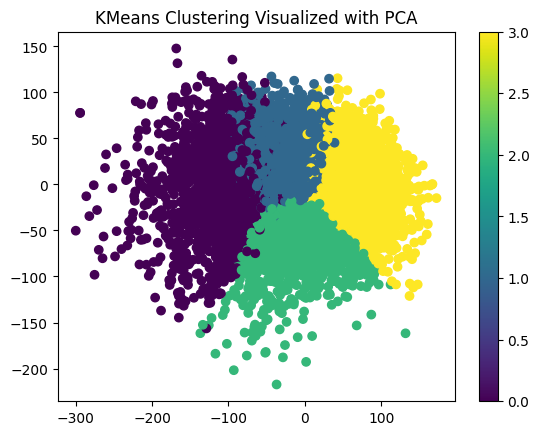

In [67]:
# Apply PCA to reduce dimensions to 2D for visualization
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Now visualize in 2D after PCA
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=mbkmeans_clusters, cmap='viridis')
plt.colorbar()
plt.title('KMeans Clustering Visualized with PCA')
plt.show()

In [68]:
# Assuming mbkmeans_clusters is an array of cluster labels
unique_clusters, counts = np.unique(mbkmeans_clusters, return_counts=True)

# This will print the cluster labels and their respective counts
for cluster, count in zip(unique_clusters, counts):
    print(f"Cluster {cluster}: {count} members")

Cluster 0: 2780 members
Cluster 1: 6416 members
Cluster 2: 3138 members
Cluster 3: 7535 members


In [69]:
num_clusters = len(np.unique(mbkmeans_clusters))  # Get the number of clusters
cluster_labels = to_categorical(mbkmeans_clusters, num_classes=num_clusters)

In [70]:
# Perform train-test split
X_train, X_test, y_train, y_test = train_test_split(features_scaled, cluster_labels, test_size=0.8, random_state=42)

In [71]:
model = Sequential()

# Input layer (based on your extracted feature dimensions)
model.add(Dense(128, activation='relu', input_dim=features_scaled.shape[1]))
model.add(Dropout(0.5))

# Hidden layer
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))

# Output layer for predicting clusters
model.add(Dense(num_clusters, activation='softmax'))

# Compile the model
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

c:\Users\Shank\anaconda3\envs\dsenv3\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [72]:
# Train the model using the training data
model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

Epoch 1/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 9s 65ms/step - accuracy: 0.6195 - loss: 5.8852 - val_accuracy: 0.8530 - val_loss: 0.9880
Epoch 2/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.7566 - loss: 3.6295 - val_accuracy: 0.8688 - val_loss: 0.5513
Epoch 3/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8032 - loss: 1.9248 - val_accuracy: 0.8606 - val_loss: 0.4040
Epoch 4/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8226 - loss: 1.2124 - val_accuracy: 0.8486 - val_loss: 0.3280
Epoch 5/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 51ms/step - accuracy: 0.8386 - loss: 0.8945 - val_accuracy: 0.8745 - val_loss: 0.3270
Epoch 6/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 7s 52ms/step - accuracy: 0.8516 - loss: 0.6853 - val_accuracy: 0.8734 - val_loss: 0.3211
Epoch 7/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8485 - loss: 0.5523 - val_accuracy: 0.8391 - val_loss: 0.3207
Epoch 8/10
125/125 ━━━━━━━━━━━━━━━━━━━━ 6s 52ms/step - accuracy: 0.8551 - loss: 0.4996 - val_accu

In [73]:
# Step 1: Predict on the test set
y_pred = model.predict(X_test)

# Step 2: Convert predictions and true labels from one-hot encoding back to class labels
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

497/497 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step


In [74]:
print("Classification Report:\n")
print(classification_report(y_true_classes, y_pred_classes))

Classification Report:

              precision    recall  f1-score   support

           0       0.73      0.96      0.83      2232
           1       0.90      0.74      0.81      5115
           2       0.93      0.79      0.85      2486
           3       0.90      0.98      0.93      6063

    accuracy                           0.87     15896
   macro avg       0.86      0.87      0.86     15896
weighted avg       0.88      0.87      0.87     15896



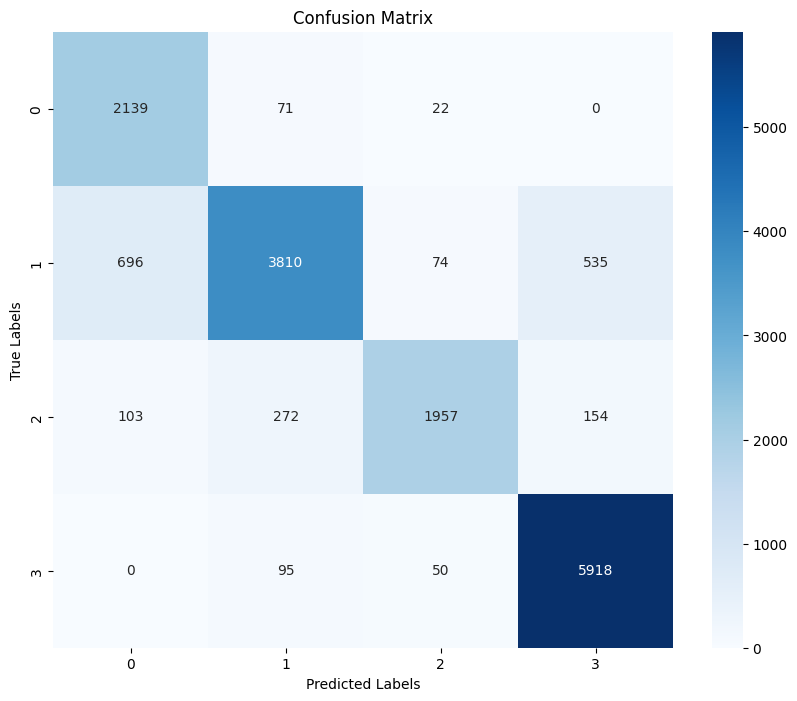

In [75]:
conf_matrix = confusion_matrix(y_true_classes, y_pred_classes)

# Step 5: Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
plt.title("Confusion Matrix")
plt.ylabel('True Labels')
plt.xlabel('Predicted Labels')
plt.show()

In [76]:
bp_song = pd.read_csv('data/bp_song.csv')

In [77]:
def compute_similarity(features_list, input_feature_vector, metric='euclidean'):
    if metric == 'euclidean':
        distances = [euclidean(input_feature_vector, feature) for feature in features_list]
    # You can add other metrics like cosine similarity
    return np.array(distances)

In [78]:
def recommend_items(input_track_id, features_list, track_ids_list, bp_song=bp_song, top_n=5):
    # Find the index of the input track's features
    input_index = track_ids_list.index(input_track_id)
    
    # Get the feature vector of the input track
    input_feature_vector = features_list[input_index]
    
    # Compute similarity between the input track and all other tracks
    similarities = compute_similarity(features_list, input_feature_vector, metric='euclidean')
    
    # Get the indices of the top_n most similar tracks (excluding the input track itself)
    most_similar_indices = similarities.argsort()[1:top_n + 1]  # Exclude the input track itself
    
    # Fetch the track_ids of the most similar items
    recommended_track_ids = [track_ids_list[idx] for idx in most_similar_indices]
    
    # Fetch the corresponding song titles and artists from the bp_song DataFrame
    recommended_songs = bp_song[bp_song['track_id'].isin(recommended_track_ids)]
    
    return recommended_songs[['track_id', 'song']]

In [80]:
input_track_id = 4993057  # Example track_id
top_n_recommendations = 5  # Get top 5 recommendations

# Fetch the input song's title and artist
input_song_info = bp_song[bp_song['track_id'] == input_track_id]['song'].values[0]

# Get the top N recommended songs
recommended_songs = recommend_items(input_track_id, features_scaled, track_id_list, bp_song, top_n=top_n_recommendations)

# Output message with input song and recommendations
print(f"Top {top_n_recommendations} recommendations for {input_song_info}:\n")
print(recommended_songs)

Top 5 recommendations for Booyah feat. We Are Loud feat. Sonny Wilson by Showtek, Sonny Wilson, We Are Loud:

         track_id                                               song
2815019   6024493                     Street Gang by Richard H. Kirk
3337845   6964058                          Folie à deux by Mechanist
5986043  11717401                         Test Drive by Dura, Oziriz
9090506  16185430  Surrender (feat. Shanokee) (Arctic Moon Remix)...
9801787  17049495                             The Dizko by Argy (UK)


In [81]:
np.save('data/audio_features_list.npy', features_scaled)
np.save('data/audio_track_ids_list.npy', track_id_list)